# モジュール準備

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 14.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=4390f0375cb455b573ae92f06e9cf3d7026982fa0859c86c91349fcb052481cd
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [ ]:
import os
import ast
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import japanize_matplotlib
import tarfile
import xml.etree.ElementTree as ET
import tqdm
import re
from collections import namedtuple
from typing import List, Tuple, Optional, Union
from itertools import count
from PIL import Image
import math
import collections
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle

In [ ]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

pd.options.display.max_info_columns = 200
pd.options.display.max_info_rows = 200

pd.options.display.max_colwidth = 200
pd.options.display.max_rowwidth = 200

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

# データ

In [ ]:
# Colaboratory側に格納用ディレクトリを事前に作成しておく
local_folder_name = 'tenhou'
os.mkdir(local_folder_name)

In [ ]:
folder_path = "/content/drive/MyDrive/mahjong/tenhou"
file_name = "2019.tar.xz"

with tarfile.open(os.path.join(folder_path, file_name)) as tar:
    tar.extractall("/content/tenhou/")

In [ ]:
for file_name in [str(i)+".tar.xz" for i in list(range(2012, 2019))]:
  folder_path = "/content/drive/MyDrive/mahjong/tenhou"
  with tarfile.open(os.path.join(folder_path, file_name)) as tar:
      tar.extractall("/content/tenhou/")

In [ ]:
folder_path = "/content/tenhou/2019/"
input_files = os.listdir(folder_path)
len(input_files)

In [ ]:
# 複数年やる
rf_list = []

for folder_path in ["/content/tenhou/" + str(i) + "/" for i in list(range(2012, 2020))]:
  print(folder_path)
  input_files = os.listdir(folder_path)

  for file in tqdm.tqdm(input_files):
    try:
      root = ET.parse(os.path.join(folder_path, file)).getroot()
    except ET.ParseError:
      break
    for child in root:
      if child.tag=="INIT":
        haipai = child.attrib["hai0"]
      if re.match(r'T[0-9]', child.tag):
        tsumo = child.tag[1:]
        tsumo_flag=True
      if re.match(r'D[0-9]', child.tag):
        dahai = child.tag[1:]
        if tsumo_flag:
          ls = [haipai, tsumo, dahai]
          rf_list.append(ls)
          break

rf_df = pd.DataFrame(rf_list)
rf_df = rf_df.rename({0:"haipai", 1:"tsumo", 2:"dahai"}, axis=1)

folder_path = "/content/drive/MyDrive/mahjong/tenhou"
rf_df.to_pickle(os.path.join(folder_path, "rf_df_2012_2019.pkl"))

/content/tenhou/2012/


100%|██████████| 116985/116985 [03:22<00:00, 577.23it/s]


/content/tenhou/2013/


100%|██████████| 131838/131838 [03:45<00:00, 584.22it/s]


/content/tenhou/2014/


100%|██████████| 141132/141132 [03:59<00:00, 589.35it/s]


/content/tenhou/2015/


100%|██████████| 152280/152280 [04:17<00:00, 590.38it/s]


/content/tenhou/2016/


100%|██████████| 159665/159665 [04:27<00:00, 596.72it/s]


/content/tenhou/2017/


100%|██████████| 169384/169384 [04:42<00:00, 600.22it/s]


/content/tenhou/2018/


100%|██████████| 173548/173548 [04:22<00:00, 660.90it/s]


/content/tenhou/2019/


 43%|████▎     | 73314/171630 [01:31<02:03, 799.15it/s]


In [ ]:
print(len(rf_df))
rf_df.head()

1118146


,haipai,tsumo,dahai
0,"49,33,35,77,50,88,101,113,57,20,15,7,100",93,113
1,"22,84,131,122,115,80,66,78,135,32,27,48,67",133,115
2,"78,27,113,126,66,87,35,65,0,47,107,111,114",88,107
3,"62,77,36,118,61,73,50,109,74,34,54,107,102",53,118
4,"18,30,72,85,68,74,132,87,37,116,93,62,118",92,30


## データセット化

In [ ]:
folder_path = "/content/drive/MyDrive/mahjong/tenhou"
rf_df = pd.read_pickle(os.path.join(folder_path, "rf_df_2012_2019.pkl"))

In [ ]:
def hai_convert_str(id):
  id_int = int(id)
  hai = ["一", "二", "三", "四", "五", "六", "七", "八", "九", #萬子
        "①", "②", "③", "④", "⑤", "⑥", "⑦", "⑧", "⑨", #筒子
        "1", "2", "3", "4", "5", "6", "7", "8", "9", #索子
        "東", "南", "西", "北", "白", "發", "中"]
  return hai[id_int]

In [ ]:
rf_df["haipai"] = rf_df.haipai.apply(lambda x: [int(i) for i in x.split(",")])
rf_df["tsumo"] = rf_df.tsumo.apply(lambda x: int(x))
rf_df["dahai"] = rf_df.dahai.apply(lambda x: int(x))
rf_df["tehai"] = rf_df[["haipai", "tsumo"]].apply(lambda x: sorted(x[0]+[x[1]]), axis=1)

rf_df["tehai_hai_id"] = rf_df.tehai.apply(lambda x: [id_int >> 2 for id_int in x])
rf_df["dahai_hai_id"] = rf_df.dahai.apply(lambda x: x >> 2)

rf_df["tehai_hai_str"] = rf_df.tehai_hai_id.apply(lambda x: [hai_convert_str(i) for i in x])
rf_df["dahai_hai_str"] = rf_df.dahai_hai_id.apply(lambda x: hai_convert_str(x))

In [ ]:
len(rf_df)

1118146

# EDA

In [ ]:
eda_df = pd.DataFrame(rf_df["dahai_hai_id"].value_counts()).sort_index().rename(columns={"dahai_hai_id": "value"})
hai = ["一", "二", "三", "四", "五", "六", "七", "八", "九", #萬子
        "①", "②", "③", "④", "⑤", "⑥", "⑦", "⑧", "⑨", #筒子
        "1", "2", "3", "4", "5", "6", "7", "8", "9", #索子
        "東", "南", "西", "北", "白", "發", "中"]
eda_df["dahai_hai_str"] = hai

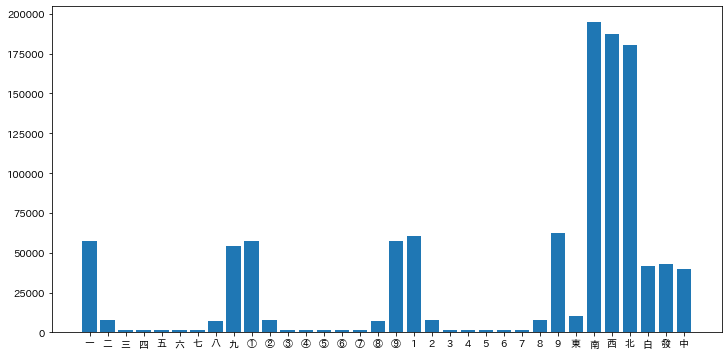

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
plt.bar(eda_df["dahai_hai_str"], eda_df["value"])
ax.set_xticks(range(0,34))

# モデル

In [ ]:
def tehai_2d_pretrain(tehai: List) -> torch.Tensor:
  tehai = [id_int >> 2 for id_int in tehai]
  c = collections.Counter(tehai)
  tehai_ar = np.zeros((3*9+7)*4)
  for i in c.items():
    hai_id = i[0] # 牌の種類 0index
    hai_times = i[1] # 枚数
    hai_id_list = [hai_id*4+i for i in range(hai_times)]
    for j in hai_id_list:
      tehai_ar[j] = 1
  tehai_m = tehai_ar[0:9*1*4].copy().reshape([-1, 4]) # 4, 9
  tehai_p = tehai_ar[9*1*4:9*2*4].copy().reshape([-1, 4])
  tehai_s = tehai_ar[9*2*4:9*3*4].copy().reshape([-1, 4])
  tehai_z = tehai_ar[9*3*4:].copy().reshape([-1, 4])
  tehai_ar = np.concatenate([tehai_m, tehai_p, tehai_s, tehai_z], 0)# (36, 4)
  
  tehai_all = torch.tensor(np.array(tehai_ar), dtype=torch.float32).unsqueeze(0) # 1, 34, 4

  return tehai_all # チャンネル数、枚数、牌

In [ ]:
class CNN_mask_2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3,1), padding=(2,0))        
        self.bn1 = nn.BatchNorm2d(4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,1), padding=(2,0))
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,1), padding=(2,0))
        self.bn3 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(5120, 34)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)

        # マスク
        x = F.relu(x)
        mask, _  = input.max(dim=3)
        mask = mask.squeeze()
        x = torch.mul(x, mask)

        return x

## 学習

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, rf_df):
    self.tehai_list = rf_df["haipai"].tolist()
    self.dahai = rf_df["dahai_hai_id"].tolist()

  def __len__(self):
    return len(self.tehai_list)

  def __getitem__(self, index):
    tehai = self.tehai_list[index]
    tehai = tehai_2d_pretrain(tehai)
    dahai = self.dahai[index]

    return tehai, dahai

In [ ]:
NUM_CLASSES = 32
BATCH_SIZE = 256
TRAIN_SIZE = int(len(rf_df)//(BATCH_SIZE*10)*(BATCH_SIZE*10)*0.6)
VALID_SIZE = int(len(rf_df)//(BATCH_SIZE*10)*(BATCH_SIZE*10)*0.3)
TEST_SIZE = int(BATCH_SIZE)

df_train, df_val = train_test_split(rf_df, train_size=TRAIN_SIZE)
df_val, df_test = train_test_split(df_val, train_size=VALID_SIZE, test_size=TEST_SIZE)

train_dataset = MyDataset(df_train)
val_dataset = MyDataset(df_val)
test_dataset = MyDataset(df_test)

# データローダーの作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    )
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    )
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    )

In [ ]:
WEIGHT_DECAY = 0.005
LEARNING_RATE = 0.001
EPOCH = 100

# 学習時と検証時で分けるためディクショナリを用意
dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

net = CNN_mask_2d().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()
        else:
            net.eval()

        epoch_loss=0
        epoch_corrects=0

        for (inputs, labels) in dataloaders_dict[phase]:
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)
                epoch_corrects += torch.sum(preds == labels.data)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
        print('{} Loss: {} Acc: {}'.format(phase, epoch_loss, epoch_acc))

epoch 1
train Loss: 1.36403443069633 Acc: 0.5906545656536697
val Loss: 1.317525114305887 Acc: 0.5994839449541285
epoch 2
train Loss: 1.3085663555594396 Acc: 0.6024673881880734
val Loss: 1.310180503658563 Acc: 0.6018491972477065
epoch 3
train Loss: 1.3013884739135748 Acc: 0.603988974101682
val Loss: 1.3054741831547623 Acc: 0.6014549885321101
epoch 4
train Loss: 1.2976517418929197 Acc: 0.6052283424120796
val Loss: 1.3028287815573747 Acc: 0.6022583381116208
epoch 5
train Loss: 1.2958270760441044 Acc: 0.6054239535550459
val Loss: 1.3018125955482507 Acc: 0.6045429568042814
epoch 6
train Loss: 1.2946807137186374 Acc: 0.6062661267201835
val Loss: 1.301981065615966 Acc: 0.6038202408256881
epoch 7
train Loss: 1.2932706205715463 Acc: 0.6065363986047401
val Loss: 1.3030190967274005 Acc: 0.6054597907110092
epoch 8
train Loss: 1.2922910563533825 Acc: 0.6072143181383792
val Loss: 1.3003690336640092 Acc: 0.6045549025229358
epoch 9
train Loss: 1.2920499796714258 Acc: 0.6071949063455657
val Loss: 1.299

## 予測

In [ ]:
for (inputs, labels) in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)

In [ ]:
df_test.head(1)

,haipai,tsumo,dahai,tehai,tehai_hai_id,dahai_hai_id
1059889,"[87, 22, 97, 28, 99, 12, 134, 122, 125, 48, 6, 11, 96]",27,122,"[6, 11, 12, 22, 27, 28, 48, 87, 96, 97, 99, 122, 125, 134]","[1, 2, 3, 5, 6, 7, 12, 21, 24, 24, 24, 30, 31, 33]",30


In [ ]:
df_test["predicted_label"] = preds.cpu()

df_test["predicted_label_str"] = df_test.predicted_label.apply(lambda x: hai_convert_str(x))

df_test[["tehai_hai_str", "dahai_hai_str", "predicted_label_str"]].head(100)

,tehai_hai_str,dahai_hai_str,predicted_label_str
1059889,"[二, 三, 四, 六, 七, 八, ④, 4, 7, 7, 7, 北, 白, 中]",北,北
633019,"[五, 六, 八, 八, ②, ③, ⑦, 1, 2, 3, 東, 南, 白, 中]",白,南
355825,"[一, 三, 八, 九, ②, ③, ⑥, ⑧, 7, 8, 9, 9, 東, 南]",南,南
104451,"[二, 四, ①, ④, ⑤, ⑤, ⑥, 1, 1, 2, 3, 9, 西, 中]",西,西
321776,"[三, 七, 七, ⑥, ⑦, ⑨, 6, 8, 東, 南, 北, 白, 發, 中]",⑨,南
664217,"[一, 三, 九, ①, ⑧, ⑧, 1, 2, 3, 4, 5, 東, 南, 發]",南,南
71199,"[一, 七, ②, ②, ④, ⑤, ⑧, 1, 3, 5, 6, 7, 8, 西]",西,西
310299,"[二, 二, 三, 六, 七, 七, 八, ①, ④, 2, 6, 8, 9, 南]",南,①
734493,"[三, 四, 五, 七, 八, ⑦, 2, 2, 5, 5, 9, 東, 白, 中]",9,9
340704,"[二, 三, 五, 七, 九, ②, ⑤, ⑦, 3, 5, 7, 9, 東, 發]",發,發
